<center>
    <h1><font size="16">Especialización en Estadística</font></h1>
    <h1><font size="12">SERIES DE TIEMPO</font></h1>
</center>

<h2>🎓 Taller Práctico – Evaluación de Modelos de Pronóstico</h2>

<h3>📘 Introducción</h3>
<p>En este taller trabajaremos con la serie <strong>AirPassengers</strong> para evaluar el desempeño de diferentes modelos de pronóstico. Nos centraremos en la comparación entre modelos manuales (ARIMA y SARIMA) y modelos automáticos (auto.arima), utilizando métricas como <strong>MAE, RMSE, MAPE y MASE</strong>. También exploraremos brevemente cómo implementar una validación cruzada adaptada a series de tiempo.</p>

<h3>🎯 Objetivos</h3>
<ul>
  <li>Comparar modelos de pronóstico mediante métricas estándar.</li>
  <li>Visualizar y analizar residuos para evaluar la validez de los modelos.</li>
  <li>Aplicar técnicas básicas de validación cruzada temporal.</li>
</ul>

**📊 Análisis de la serie `AirPassengers`**

---

<h3>📦 Requisitos previos</h3>

In [1]:
# Cargar paquetes necesarios

library(fpp3)      # Framework moderno para series de tiempo:
                   # incluye tsibble, modelado ARIMA/ETS y visualización con autoplot.

library(forecast)  # Paquete tradicional con funciones como forecast(), accuracy(),
                   # y herramientas complementarias como tsCV() y checkresiduals().

library(yardstick) # Permite calcular métricas personalizadas de error (MAE, RMSE, MAPE, etc.)
                   # útil especialmente para objetos fuera del ecosistema forecast.

library(ggplot2)   # Sistema de visualización de datos. Usado para personalizar gráficos
                   # y construir visualizaciones comparativas de errores.

library(tsibble)   # Estructura moderna de datos para series de tiempo en R;
                   # imprescindible para trabajar con fpp3 y validación cruzada.


Registered S3 method overwritten by 'tsibble':
  method               from 
  as_tibble.grouped_df dplyr

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────── fpp3 1.0.1 ──

✔ tibble      3.2.1     ✔ tsibble     1.1.6
✔ dplyr       1.1.4     ✔ tsibbledata 0.4.1
✔ tidyr       1.3.1     ✔ feasts      0.4.1
✔ lubridate   1.9.4     ✔ fable       0.4.1
✔ ggplot2     3.5.2     

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────── fpp3_conflicts ──
✖ lubridate::date()    masks base::date()
✖ dplyr::filter()      masks stats::filter()
✖ tsibble::intersect() masks base::intersect()
✖ tsibble::interval()  masks lubridate::interval()
✖ dplyr::lag()         masks stats::lag()
✖ tsibble::setdiff()   masks base::setdiff()
✖ tsibble::union()     masks base::union()

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Adjuntando el paquete: 'yardstick

🔍 **Preparación de la serie**

A continuación, vamos a realizar la carga y transformación de la serie `AirPassengers`. Luego aplicaremos las transformaciones necesarias para su análisis y modelado posterior:

In [2]:
# Serie original: pasajeros mensuales de aerolíneas
ap <- AirPassengers

# Transformación a logaritmo natural
log_ap <- log(ap)

# Diferenciación regular (orden 1)
diff1_log_ap <- diff(log_ap)

# Diferenciación estacional (periodo 12)
diff2_log_ap <- diff(diff1_log_ap, lag = 12)

# También puede usarse directamente:
# diff2_log_ap <- diff(log_ap, differences = 1) |> diff(lag = 12)

## 🔧 Estimación de parámetros

Una vez transformada la serie y confirmada su **estacionariedad**, podemos proceder a la **identificación estructural del modelo ARIMA/SARIMA**. Esto implica determinar los órdenes $p, d, q$ (y si es estacional, $P, D, Q$) con base en los patrones de **autocorrelación** y **autocorrelación parcial**.

### 🔍 1. Verificación de estacionariedad con prueba ADF


In [3]:
library(tseries)

# Segunda diferenciación sobre la serie logarítmica
diff2_log_ap <- diff(diff(log_ap), lag = 12)

# Prueba Dickey-Fuller aumentada
adf.test(diff2_log_ap)


Warning message in adf.test(diff2_log_ap):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  diff2_log_ap
Dickey-Fuller = -5.1993, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


📌 **Preguntas:**
- ¿Qué nos dice la prueba sobre la estacionariedad de la serie?
- ¿Las otras expresiones tienen la misma característica?
- ¿Cuál crees trasnformación deberíamos emplear?

---

<h3>🔍 2. Análisis gráfico con ACF y PACF</h3>



Adjuntando el paquete: 'ggpubr'


The following object is masked from 'package:forecast':

    gghistogram




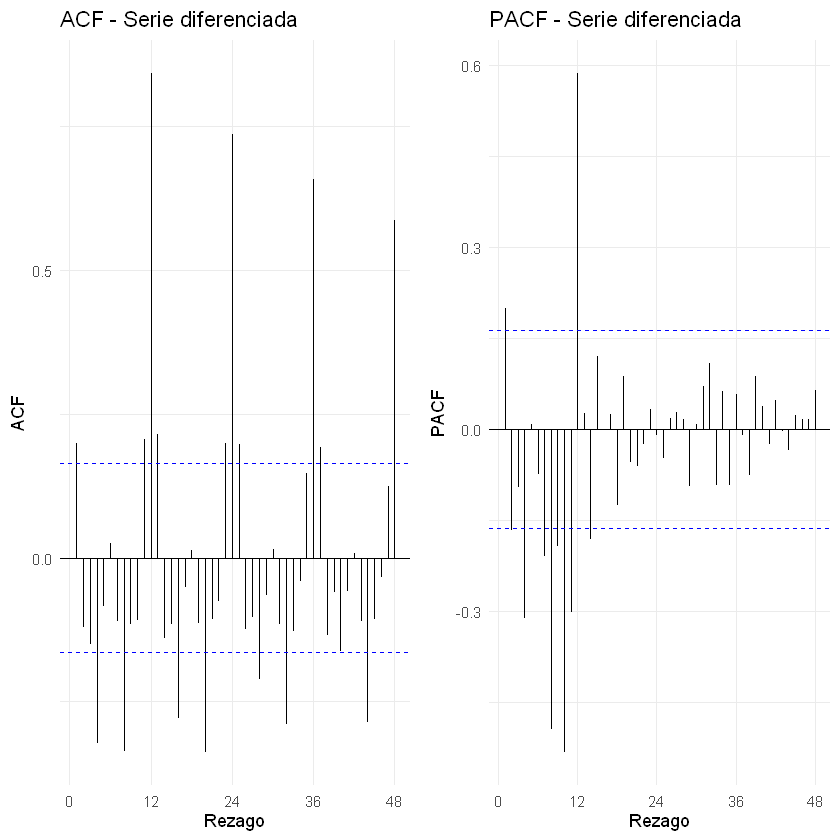

In [4]:
library(forecast)
library(ggpubr)

ggarrange(
  ggAcf(diff1_log_ap, lag.max = 48) +
    labs(title = "ACF - Serie diferenciada", x = "Rezago", y = "ACF") +
    theme_minimal(),

  ggPacf(diff1_log_ap, lag.max = 48) +
    labs(title = "PACF - Serie diferenciada", x = "Rezago", y = "PACF") +
    theme_minimal()
)


📌 **Preguntas:**
- ¿Qué nos indican las gráficas `ACF` y `PACF`?
- ¿Difiere el comportamiento con el de las otras y transformaciones?
- ¿Cómo deberíamos utilizar estos resultados?

---

### 📐 3. Identificación asistida con `armasubsets()`


Registered S3 methods overwritten by 'TSA':
  method       from    
  fitted.Arima forecast
  plot.Arima   forecast


Adjuntando el paquete: 'TSA'


The following object is masked from 'package:yardstick':

    spec


The following objects are masked from 'package:stats':

    acf, arima


The following object is masked from 'package:utils':

    tar




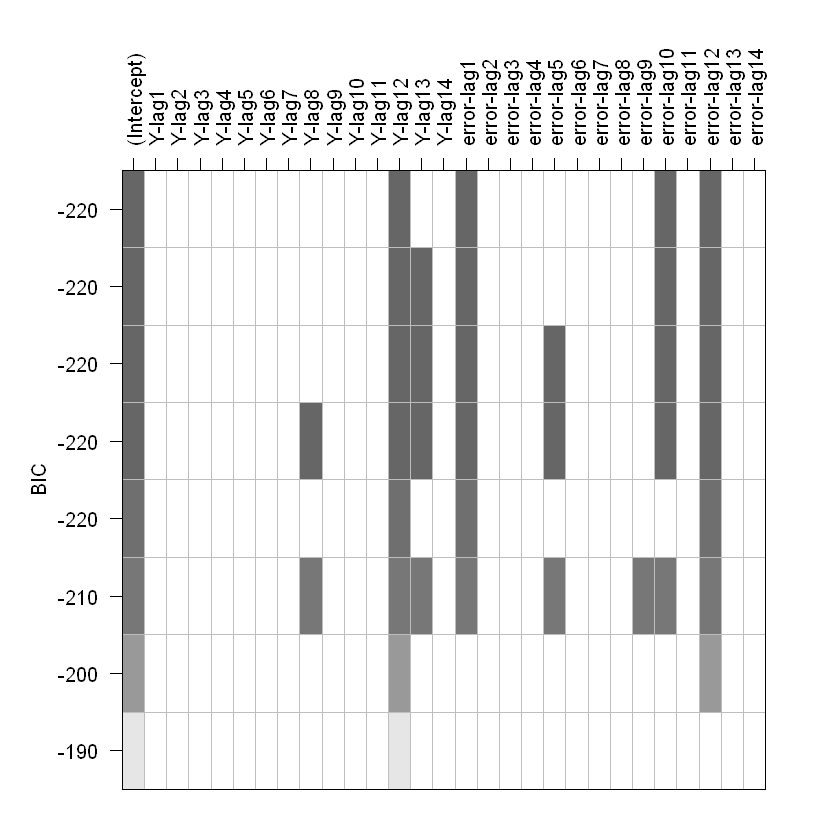

In [5]:
library(TSA)
plot(armasubsets(diff1_log_ap, nar = 14, nma = 14, ar.method = "ols") )

📌 **Preguntas:**
- ¿Qué representan los ejes de esta gráfica y cómo se interpretan?
- ¿Las otras expresiones tienen la misma característica?
- ¿Cuál crees que es la utilidad de esta gráfica?

---

### 🧮 4. Análisis estructural con `eacf()`

In [6]:
eacf(diff2_log_ap)

AR/MA
  0 1 2 3 4 5 6 7 8 9 10 11 12 13
0 x o x o o o o o o o o  x  o  o 
1 o o x o o o o o x o o  x  o  o 
2 o x x o o o o o x o o  x  o  o 
3 x x o x o o o o o o o  x  o  o 
4 x x x x o o o o o o o  x  o  o 
5 x o x o o o o o o o o  x  o  o 
6 x x o o o o o o o o o  x  o  o 
7 x x o o o o o o o o o  x  o  o 


📌 **Preguntas:**
- ¿Cómo debemos interpretar esta matriz?
- ¿Nos muestra un único resultado o nos ofrece otras opciones?
- ¿Cuál es la utilidad de este rewsultado?

---

### 🧪 Paso 5: Ajustar el modelo candidato manualmente

In [7]:
m1 <- arima(log_ap,
            order = c(1,1,1),
            seasonal = list(order = c(0,1,1), period = 12))


📌 **Preguntas:**
- ¿Qué implican los resultados de este modelo?
- ¿Basta con estos resultados o deberíamos probar otras combinaciones?
- ¿Si es el caso, cómo podemos comparar de manera sencilla los modelos obtenidos?

---

### 🔍 Paso 6: Diagnóstico del modelo

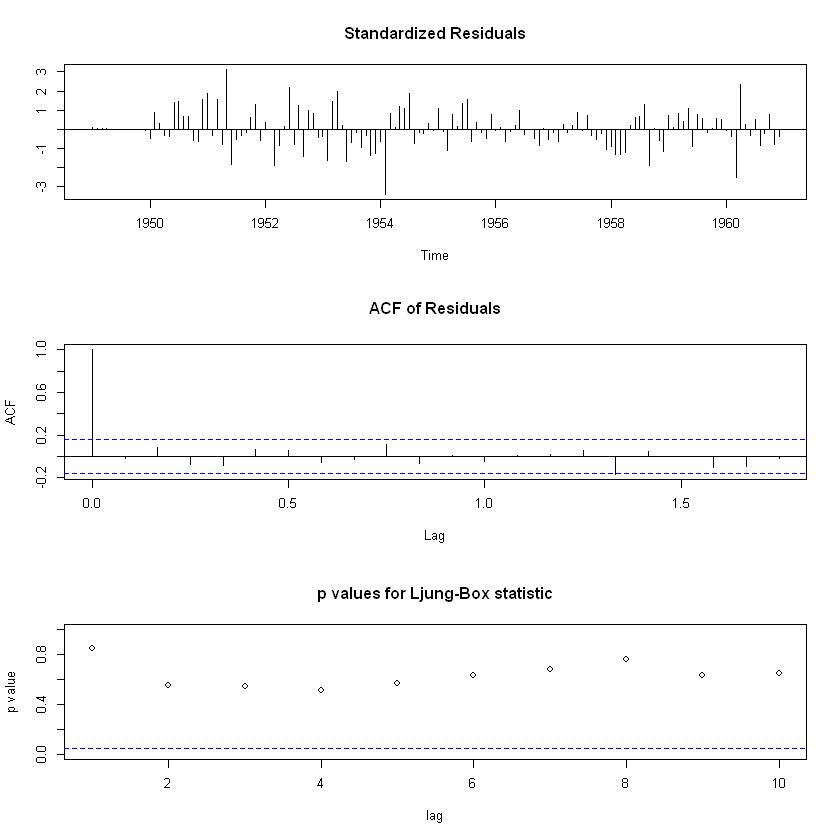

In [8]:
tsdiag(m1)

📌 **Preguntas:**
- ¿Cómo deberíamos interpretar cada gráfica?
- ¿Es suficiente para considerar como bueno el modelo?
- ¿Qué crees que deberíamos hacer si los resultados fueran diferentes?

---

📌 2. Prueba puntual de Ljung-Box a 24 rezagos

In [9]:
Box.test(residuals(m1), lag = 24, type = "Ljung-Box")


	Box-Ljung test

data:  residuals(m1)
X-squared = 25.044, df = 24, p-value = 0.4034


📌 **Preguntas:**
- ¿Cómo debemos interpretar estos resultados?
- ¿Es suficiente para seleccionar el modelo?
- ¿Si aplicamos la prueba a los otros modelos posibles los resultados serán diferentes?

---
<h3>🔧 Sección 2: Automatización del ajuste y evaluación de modelos</h3>

📌 **Automatización con `auto.arima()`**

El ajuste automático de modelos ARIMA/SARIMA se ha convertido en una herramienta fundamental para el análisis de series de tiempo. En R, la función `auto.arima()` del paquete `forecast` permite seleccionar automáticamente los órdenes del modelo:  
- **(p, d, q)**: parte no estacional.  
- **(P, D, Q)**: parte estacional (si se activa `seasonal = TRUE`). 

In [10]:
auto.arima(log_ap)

Series: log_ap 
ARIMA(0,1,1)(0,1,1)[12] 

Coefficients:
          ma1     sma1
      -0.4018  -0.5569
s.e.   0.0896   0.0731

sigma^2 = 0.001371:  log likelihood = 244.7
AIC=-483.4   AICc=-483.21   BIC=-474.77

📌 **Preguntas:**
- ¿Cómo interpretarías los resultados?
- ¿Crees que obtendrías algo diferente si se usan las otras transformaciones?
- ¿Cuál transformación debería utilizar?
- ¿Podría usar directamente la serie o debo transformarla?
---
<h3>🧪 Evaluación de modelos ARIMA/SARIMA</h3>

Evaluar el desempeño de modelos ajustados nos permite **elegir el mejor modelo no solo por ajuste, sino también por parsimonia, comportamiento de residuos y capacidad predictiva**.

<h4>🧮 Cálculo de métricas: AIC, AICc, BIC</h4>

Comparamos dos modelos: el modelo manual (`m1`) y el automático (`ma`):

In [11]:
summary(m1)

Warning message in trainingaccuracy(object, test, d, D):
"test elements must be within sample"



Call:
arima(x = log_ap, order = c(1, 1, 1), seasonal = list(order = c(0, 1, 1), period = 12))

Coefficients:
         ar1      ma1     sma1
      0.1960  -0.5784  -0.5643
s.e.  0.2475   0.2132   0.0747

sigma^2 estimated as 0.001341:  log likelihood = 244.95,  aic = -483.9

Training set error measures:
              ME RMSE MAE MPE MAPE
Training set NaN  NaN NaN NaN  NaN

In [12]:
ma <- auto.arima(log_ap)
summary(ma)

Series: log_ap 
ARIMA(0,1,1)(0,1,1)[12] 

Coefficients:
          ma1     sma1
      -0.4018  -0.5569
s.e.   0.0896   0.0731

sigma^2 = 0.001371:  log likelihood = 244.7
AIC=-483.4   AICc=-483.21   BIC=-474.77

Training set error measures:
                       ME       RMSE        MAE        MPE      MAPE      MASE
Training set 0.0005730622 0.03504883 0.02626034 0.01098898 0.4752815 0.2169522
                   ACF1
Training set 0.01443892

📌 **Preguntas:**
- ¿Cómo interpretarías los resultados?
- ¿Cuál modelo es más robusto?
- ¿Por qué es más robusto?
- ¿Qué hago si encuentro un modelo con mejor `AIC`que el automático, pero no muestra sus métricas completas?
---
<h4>🧪 Diagnóstico de los residuos</h3>


	Ljung-Box test

data:  Residuals from ARIMA(1,1,1)(0,1,1)[12]
Q* = 25.044, df = 21, p-value = 0.2453

Model df: 3.   Total lags used: 24



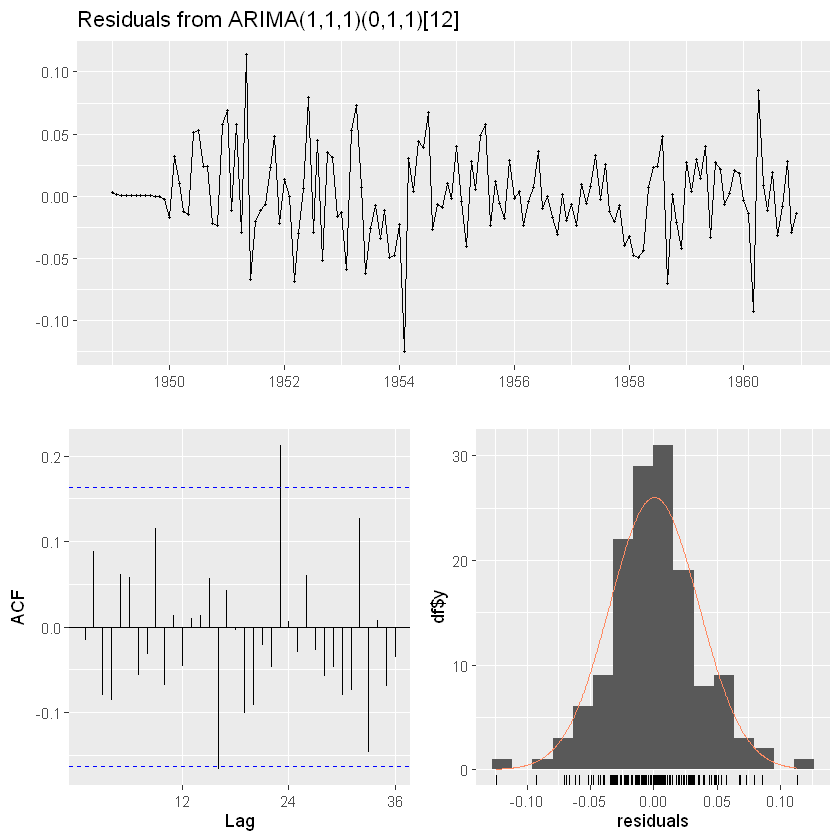

In [13]:
library(forecast)

# Diagnóstico gráfico del modelo manual
checkresiduals(m1)

📌 **Preguntas:**

- ¿Cuál es la interpretación que debo dar a estos resultados?
- ¿Eso significa que el modelo es un buen modelo?
- Si los resultados no son favorables, pero no tengo más modelos posibles ¿Qué debería hacer?
---
<h3> 3. 🔮 Proyección y visualización de pronósticos</h3>

Una vez validado el modelo, se procede a generar los pronósticos y visualizarlos junto con la serie observada.

🛠 Paso 1: Definir el modelo (si no está hecho). Como ya sabemos el modelo automático es el más eficiente.

In [14]:
# ma <- aiuto.arima(log_ap)

🛠 Paso 2: Proyectar hacia el futuro

In [15]:
library(forecast)

# Generar pronóstico para 24 meses (2 años)
pronostico <- forecast(ma, h = 24)

🛠 Paso 3: Visualizar resultados con intervalos

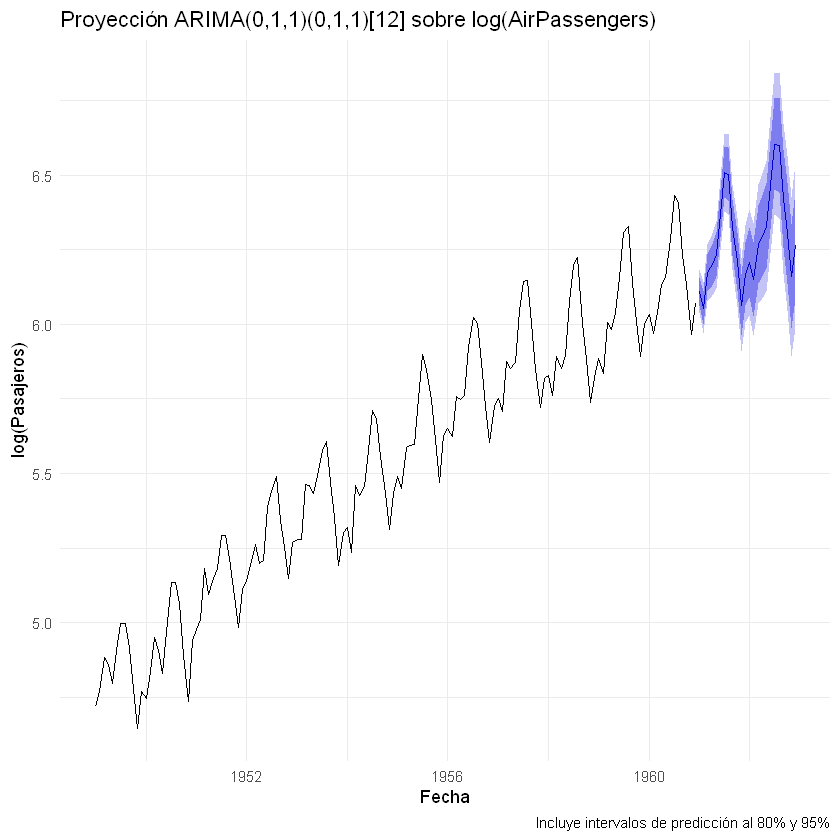

In [16]:
autoplot(pronostico) +
  labs(
    title = "Proyección ARIMA(0,1,1)(0,1,1)[12] sobre log(AirPassengers)",
    x = "Fecha", y = "log(Pasajeros)",
    caption = "Incluye intervalos de predicción al 80% y 95%"
  ) +
  theme_minimal()

📌 **Preguntas:**

- El modelo tiene transformación logarítmica ¿Son estos resultados equivalentes a la serie original?
- ¿Qué debo hacer si quiero proyectar la serie original?
- ¿Y si lo hago con el modelo automático para la serie sin transformar?

---

<h3>✅ Cierre del taller</h3>

📌 Este taller ha permitido explorar paso a paso:

- La **selección manual** del modelo.
- La **selección automática** del modelo.
- La selección del **modelo adecuado**.
- El diagnóstico del modelo seleccionado

> En el siguiente bloque se realizará la evaluación práctica del modelo mediante las métricas de diagnóstico y el método de validación cruzada.